# Deep Learning-Based Method for Solving High Dimensional PDEs (BSDEs) Using TensorFlow (Finance Example) with Code Explanation (A. HAIDA May 10th, 2023)

## Introduction

We propose an algorithm for solving parabolic partial differential equations
(PDEs) and backward stochastic differential equations (BSDEs) in high dimension,
by making an analogy between the BSDE and reinforcement learning with the gradient of the solution playing the role of the policy function, and the loss function given
by the error between the prescribed terminal condition and the solution of the BSDE.
The policy function is then approximated by a neural network, as is done in deep reinforcement learning. Numerical results using TensorFlow illustrate the efficiency
and accuracy of the proposed algorithms for a 100-dimensional nonlinear PDE
from finance i.e."Nonlinear Black-Scholes Equation with default risk".

So, in the general case, we are interested in the PDEs of the form :
\
\
$$
\begin{aligned}
   \partial_t u(t,x) 
   + \frac{1}{2} \sigma \sigma^T(t,x) : \nabla^2 u(t,x) 
   + \mu(t,x) \cdot \nabla u(t,x) 
   + f(t,x,u(t,x),\sigma^T(t,x) \nabla u(t,x)) 
   &= 0,\\
   u(T,x) &= g(x)
\end{aligned}
$$
with :    
$$
\begin{aligned}
\quad &&(t,x) \in [0,T) \times \mathbb R^d,\\
\quad &&x \in  \mathbb R^d
\end{aligned}
$$
\
\
with drift $\mu\colon[0,T] \times \mathbb R^d \to \mathbb R^d$, diffusion $\sigma\colon[0,T] \times\mathbb R^d \to \mathbb R^{d \times d}$ and final data $g\colon\mathbb R^d \to \mathbb R$ as before.
The function $f\colon [0,T] \times \mathbb R^d \times \mathbb R \times \mathbb R^d \to \mathbb R$ containing lower order terms can depend in a general way on the independent variables $t,x$ as well as on the solution $u(t,x)$  and its transformed gradient $(\sigma^T\nabla) u(t,x)$.
Here, $\nabla u(t,x)$ and $\nabla^2 u(t,x)$ denote the gradient and Hessian of the function $u$, resp., the colon sign "$:$" denotes the inner product, $A:B = \sum_{i,j=1}^d a_{ij} \, b_{ij}$.
The non-divergence form of the leading-order term as well as the specific dependence on $\sigma^T\nabla u$ again result from the connection between nonlinear PDEs and stochastic processes.
As we will see below, the presence of these dependencies requires extending the numerical solution method to include additional approximating stochastic processes for $\nabla u$.
\
\
Semilinear PDEs of the form above arise in finance, e.g., for pricing derivatives with default risk;
and in stochastic control problems.
This method is based on the PDE-SDE connection, i.e. the correspondence of nonlinear PDEs with backward stochastic differential equations (BSDEs).




## Theoretical background
The method is based on the connection of nonlinear PDEs and backward stochastic differential equations (BSDEs).
Given a filtered probability space $(\Omega, \mathcal{F}, \mathbb{P}; \mathbb{F})$ equipped with the filtration $\{\mathcal{F}_t\}_{t \in [0,T]}$ induced by a Brownian motion $\{W_t\}_{t \in [0,T]}$,
the stochastic process $\{X_t\}_{t \in [0,T]}$ describes the evolution of the state variable for all $t \in [0,T]$ via the SDE:

$$
X_t = x + \int_0^t \mu(s,X_s) \, ds + \int_0^t \sigma(s,X_s) \, dW_s,
$$

which directly implies $X_0 = x$.
The backward SDE associated with this process is

$$
Y_t = g(X_T) + \int_t^T f(s, X_s, Y_s, Z_s) \, ds - \int_t^T Z_s \cdot dW_s,
$$

which in particular implies $Y_T = g(X_T)$.

Under suitable regularity assumptions on the coefficients $\mu, \sigma, f$ and $g$, the link to the nonlinear PDE is given by the fact that for all $t \in [0,T]$ it holds $\mathbb{P}$-a.s. that

$$
Y_t = u(t,X_t) \quad \text{and} \quad Z_t = (\sigma^T \nabla u) (t, X_t).
$$

Thus, the solution $u(0, x)$ can be obtained through the knowledge of $Y_0 = u(0, X_0) = u(0, x)$.

## Forward discretization in time
We discretize the time interval $[0,T]$ into $N$ equidistant subintervals $0=t_0 < t_1 < \ldots < t_N = T$ with constant step size $\Delta t = T/N$.
To approximate $\{X_t\}_{t \in [0,T]}$, we employ the Euler-Maruyama scheme for the forward SDE which yields

$$
\tilde X_{{n+1}} = \tilde X_{n}
+ \mu(t_n, \tilde X_{n}) \, (t_{n+1} - t_n)
+ \sigma(t_n, \tilde X_{n}) \, (W_{t_{n+1}} - W_{t_n}),
$$

where $\tilde X_n \approx X_{t_n}$.
Analogously, we obtain a discretization of the backward SDE as

$$
\tilde Y_{{n+1}} = \tilde Y_{n} 
- f(t_n, \tilde X_{n}, \tilde Y_{n}, \tilde Z_{n}) \, (t_{n+1} - t_n)
+ \tilde Z_{n} \cdot ( W_{t_{n+1}} - W_{t_n}),
$$

where $\tilde Y_n \approx Y_{t_n}$ and $\tilde Z_n \approx Z_{t_n}$.
We emphasize again that we are interested in the value $\tilde Y_{0} \approx Y_0 = u(0, x)$.
Note that the increment of a Brownian motion $( W_{t_{n+1}} - W_{t_n}) \sim \mathsf{N}(0,(t_{n+1} - t_n) I_{d\times d})$ is normally distributed.

## Implementation

### 1. Import necessary packages

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from time import time

# Set data type
DTYPE='float32'
#DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE)

#### <font color='red'>Explanation</font>
- These lines import the necessary Python modules for the script, including TensorFlow for machine learning, NumPy for numerical computations, Matplotlib for plotting, and time for timing.
- The lines after set the data type for numerical computations in TensorFlow. The first line sets the data type to 32-bit floating point numbers (float32), which is the default for most applications. The second line is commented out, but it sets the data type to 64-bit floating point numbers (float64), which can be more accurate but also more computationally expensive. The last line sets the data type in TensorFlow to the chosen data type.

Note that this only affects the data type used by TensorFlow, and not the data type used by other Python modules such as NumPy or Matplotlib.

### 2. Simulation of  $\{\tilde X_{i}\}_{i=0, \ldots, N}$ and $\{W_{t_i}\}_{i=0, \ldots, N}$

In [2]:
# Final time
T = 1.

# Spatial dimensions
dim = 100

# Number of intervals in time
N = 40

# Derive time step size and t_space
dt = T/N
t_space = np.linspace(0, T, N + 1)

# Point of interest at t=0
x = np.zeros(dim)

# Diffusive and drift term is assumed to be constant
sigma = 0.2
mu = 0.02

#### <font color='red'>Explanation</font>
- This script lines set up the parameters for our problem. It specifies the final time, number of spatial dimensions, and number of intervals in time for the problem. The time step size and time space are derived based on the final time and number of intervals in time. The initial point of interest is set to a vector of zeros with the specified number of spatial dimensions. The diffusive and drift terms in the stochastic differential equation are set to constant values. The diffusive term is represented by sigma and the drift term is represented by mu. These parameters will be used in solving the stochastic control problem.

Next, we define a function to draw multiple sample paths of $\{\tilde X_{i}\}_{i=0, \ldots, N}$ and the corresponding increments of the Brownian motions $\{W_{t_i}\}_{i=0, \ldots, N}$ according to

$$
\tilde X_{{n+1}} = \tilde X_{n}
+ \mu(t_n, \tilde X_{n}) \, (t_{n+1} - t_n)
+ \sigma(t_n, \tilde X_{n}) \, ( W_{t_{n+1}} - W_{t_n}), \qquad \tilde X_0 = x,
$$

for the particular case $\mu(t,X_t) = \mu$ and $\sigma(t,X_t) \equiv \sigma I_{d \times d}$.

In [3]:
def draw_X_and_dW(num_sample, x):
    """ Function to draw num_sample many paths of the stochastic process X
    and the corresponding increments of simulated Brownian motions dW. """
    
    dim = x.shape[0]
    
    # Draw all increments of W
    dW = np.random.normal(loc=0.0, scale=np.sqrt(dt), size=(num_sample, dim, N)).astype(DTYPE)

    # Initialize the X array
    X = np.zeros((num_sample, dim, N+1), dtype=DTYPE)
    
    # Set starting point to x for each draw
    X[:, :, 0] = np.ones([num_sample, dim]) * np.ones(dim) * 100
    
    for i in range(N):
        # The Euler-Maruyama Scheme
        X[:, :, i+1] = (1 + mu * dt) * X[:, :, i] + sigma * X[:, :, i] * dW[:, :, i]
    # Return simulated paths as well as increments of Brownian motion
    return X, dW

#### <font color='red'>Explanation</font>
- This is a Python function that generates simulated paths of a stochastic process X and the corresponding increments of Brownian motion dW. The function takes two arguments: num_sample, which specifies the number of sample paths to generate, and x, which specifies the starting point for each path. The dimensions of the stochastic process X are determined by the shape of the starting point x.

- The function first generates all increments of Brownian motion dW using the NumPy random.normal() function, which generates random samples from a normal (Gaussian) distribution. The mean of the distribution is set to 0, the standard deviation is set to the square root of the time step size, and the shape of the dW array is (num_sample, dim, N), where dim is the number of spatial dimensions and N is the number of intervals in time.

- The X array is then initialized as a zeros array with shape (num_sample, dim, N+1), where N+1 is the number of time steps. The starting point for each path is set to x using NumPy broadcasting. The function then uses the Euler-Maruyama scheme to simulate the paths of X for each time step. Finally, the function returns both the simulated paths X and the increments of Brownian motion dW.

Finally, we may test the function and draw 100 samples of the process $\{\tilde X_{i}\}_{i=0,\ldots,N}$.

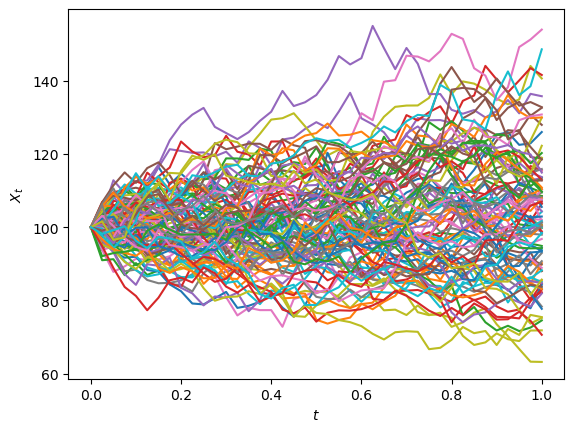

In [5]:
num_sample=100

# Draw 10 sample paths
X,dW = draw_X_and_dW(num_sample, np.zeros(1))

# Plot these paths
fig,ax = plt.subplots(1)
for i in range(num_sample):
    ax.plot(t_space,X[i,0,:])
ax.set_xlabel('$t$')
ax.set_ylabel('$X_t$');

#### <font color='red'>Explanation</font>
- This code generates 100 sample paths of a stochastic process X using the function draw_X_and_dW(), with the starting point set to zero. It then plots these paths using Matplotlib. The plt.subplots() function creates a figure object and an axes object, and returns them as a tuple. The ax.plot() function is then used to plot each of the 100 sample paths on the same graph, with time on the x-axis and the values of X on the y-axis. Finally, the x-axis and y-axis labels are set using the ax.set_xlabel() and ax.set_ylabel() functions, respectively. The resulting plot shows the behavior of the stochastic process X over time for each of the 100 sample paths

### 3. Simulation of $\{\tilde Y_{i}\}_{i=0, \ldots, N}$
A recapulation of the update formula of the value process $Y$ is:

$$
\tilde Y_{{n+1}} = \tilde Y_{n} 
- f(t_n, \tilde X_{n}, \tilde Y_{n}, \tilde Z_{n}) \, (t_{n+1} - t_n)
+ \tilde Z_{n} \cdot (W_{t_{n+1}} - W_{t_n}), \qquad \tilde Y_N = g(\tilde X_N),
$$

indicates that there are multiple unknowns present in this equation, namely

  - $\tilde Y_{0}$, an approximation of $u(0, x)$ as well as
  - $\tilde Z_{i}$, the approximations of $\sigma^T(t_i, \tilde X_{i}) \nabla u(t_i, \tilde X_{i})$ for $i = 0,\ldots,N-1$.

The unknowns $\tilde Y_{0} \approx u(0, x) \in \mathbb R$ and $\tilde Z_{0} \approx (\sigma^T \nabla u)(0, x) \in \mathbb R^d$ are treated as individual network parameters (we only need both of them in the particular point $(0,x)$) which are learned during training.

To approximate the remaining unknowns $\tilde Z_{i}$ we employ neural networks which realize the mappings $x \mapsto \sigma^T(t_i, x) \nabla u(t_i, x)$ for $i=1,\ldots,N$.

These networks have the following structure:

    Input -> BN -> (Dense -> BN -> ReLU) -> (Dense -> BN -> ReLU) -> Dense -> BN -> Output
    
Here, `BN` denotes Batch Normalization, `Dense` a fully connected layer without bias term and activation, and `ReLU` the componentwise application of the  ReLU activation function $\mathrm{relu}(x) = \max \{0,x\}$.

We define the complete network as one class derived from `tf.keras.model`.


In [6]:
class BSDEModel(tf.keras.Model):
    def __init__(self, **kwargs):
        
        # Call the initializer of tf.keras.Model
        super().__init__(**kwargs)
        
        # Initialize the value u(0, x) randomly (uniform distribution)
        u0 = np.random.uniform(.1, .3, size=(1)).astype(DTYPE)
        self.u0 = tf.Variable(u0)
        
        # Initialize the gradient nabla u(0, x) randomly (uniform distribution)
        gradu0 = np.random.uniform(-1e-1, 1e-1, size=(1, dim)).astype(DTYPE)
        self.gradu0 = tf.Variable(gradu0)
        
        # Create template of dense layer without bias and activation
        _dense = lambda dim: tf.keras.layers.Dense(
            units=dim,
            activation=None,
            use_bias=False)
        
        # Create template of batch normalization (BN) layer
        _bn = lambda : tf.keras.layers.BatchNormalization(
            momentum=.99,
            epsilon=1e-6,
            beta_initializer=tf.random_normal_initializer(0.0, stddev=0.1),
            gamma_initializer=tf.random_uniform_initializer(0.1, 0.5))
        
        
        # Initialize a list of networks approximating the gradient of u(t, x) at t_i
        self.gradui = []
        
        # Loop over number of time steps
        for _ in range(N - 1):
            
            # Batch normalization on dim-dimensional input
            this_grad = tf.keras.Sequential()
            this_grad.add(tf.keras.layers.Input(dim))
            this_grad.add(_bn())
            
            # Two hidden layers of type (Dense -> Batch Normalization -> ReLU)
            for _ in range(2):
                this_grad.add(_dense(dim+10))
                this_grad.add(_bn())
                this_grad.add(tf.keras.layers.ReLU())
                
            # Dense layer followed by batch normalization for output
            this_grad.add(_dense(dim))
            this_grad.add(_bn())
            self.gradui.append(this_grad)

#### <font color='red'>Explanation</font>
This is the implementation of the BSDE model as a subclass of the tf.keras.Model class. The constructor initializes the value of u(0, x) and the gradient of u(0, x) randomly using tf.Variable objects. It also defines a template for a fully connected neural network layer without bias and activation, as well as a batch normalization layer. The model then loops over each time step and creates a neural network approximation for the gradient of u(t, x) at that time step. Each network is constructed by adding a batch normalization layer, two hidden layers of type (Dense -> Batch Normalization -> ReLU), and a final dense layer followed by batch normalization. These networks are stored in a list <code>gradui<code/>.

Next, we define a function to draw multiple realizations of $\tilde Y_{N} \approx u(T, X_T)$ by sweeping through the network.
The intermediate values $\{\tilde Y_{i}\}_{i=0,\ldots,N-1}$ are not stored.

In [7]:
def simulate_Y(inp, model, fun_f):
    """ This function performs the forward sweep through the network.
    """
    
    X, dW = inp
    num_sample = X.shape[0]


    e_num_sample = tf.ones(shape=[num_sample, 1], dtype=DTYPE)

    # Value approximation at t0
    y = e_num_sample * model.u0

    # Gradient approximation at t0
    z = e_num_sample * model.gradu0

    for i in range(N-1):
        t = t_space[i]
        
        # Determine terms in right-hand side of Y-update at t_i
        side1 = - fun_f(t, X[:, :, i], y, z) * dt
        side2 = tf.reduce_sum(z * dW[:, :, i], axis=1, keepdims=True)
        
        # Compute new value approximations at t_{i+1}
        y = y + side1 + side2
        z = model.gradui[i](X[:, :, i + 1]) / dim

        
    # Final step
    side1 = - fun_f(t_space[N-1], X[:, :, N-1], y, z) * dt
    side2 = tf.reduce_sum(z * dW[:, :, N-1], axis=1, keepdims=True)
    y = y + side1 + side2

    return y

#### <font color='red'>Explanation</font>
- The simulate_Y function takes in the input inp, the model and the function fun_f. It performs the forward sweep through the neural network to approximate the value of y at each time step.

- It initializes the value of y and z at t0 using the model.u0 and model.gradu0 variables. Then it loops over the time steps, and for each step it computes the right-hand side terms of the Y-update using the fun_f function. It then updates the value of y and z for the next time step using the computed terms and the gradient approximation from the current time step.

- Finally, it computes the last step of the Y-update and returns the final value of y.

### 4. Evaluation of loss function

In the next step, we define the loss function, i.e., the function to be minimized.
Since $\tilde Y_N$ approximates $u(T, X_T) = g(X_T)$ we minimize the mean squared error (MSE) between $\tilde Y_N$ and $g(\tilde X_N)$.

In [8]:
def loss_fn(inp, model, fun_f, fun_g):
    """ This function computes the mean-squarred error of the difference of Y_T and g(X_T)
        inp - (X, dW)
        model - model of neural network 
        fun_f - function handle for cost function f
        fun_g - function handle for terminal condition g
    """
    X, _ = inp
    
    # Compute value estimates
    y_pred = simulate_Y(inp, model, fun_f)
        
    # Evaluate g(X_T)
    y = fun_g(X[:, :, -1])
    
    # Compute mean squared error (MSE)
    y_diff = y-y_pred    
    loss = tf.reduce_mean(tf.square(y_diff))
    
    return loss

#### <font color='red'>Explanation</font>
- This function computes the mean-squared error (MSE) loss between the value estimates y_pred and the terminal condition g(X_T) given by fun_g(X[:, :, -1]). The value estimates are obtained by simulating the system forward in time using the simulate_Y function, given the input (X, dW) and the neural network model _model. The cost function f is passed as the function handle fun_f.

### 5. Computation of the gradient with respect to the network parameters $\theta$


The next step uses the automatic differentiation functionality of TensorFlow to compute the gradient of the loss function with respect to the unknowns $\theta$, called `trainable_variables` in TensorFlow.

In [9]:
@tf.function
def compute_grad(inp, model, fun_f, fun_g):
    """ This function computes the gradient of the loss function with respect to
    the trainable variables theta.
        inp - (X, dW)
        model - model of neural network
        fun_f - function handle for cost function f
        fun_g - function handle for terminal condition g
    """
    
    with tf.GradientTape() as tape:
        loss = loss_fn(inp, model, fun_f, fun_g)
        
    grad = tape.gradient(loss, model.trainable_variables)
    
    return loss, grad

#### <font color='red'>Explanation</font>
This is a TensorFlow function decorated with @tf.function, which makes it faster by tracing the computation graph and optimizing it for the provided inputs.

The function takes four inputs:

- 1 inp: a tuple of inputs (X, dW), where X is a tensor of shape (num_sample, dim, N) and dW is a tensor of shape (num_sample, dim, N).
- 2 model: an instance of the BSDEModel class, which contains the neural network model.
- 3 fun_f: a function handle for the cost function f.
- 4 fun_g: a function handle for the terminal condition g.
The function computes the gradient of the loss function with respect to the trainable variables of the neural network model using tf.GradientTape. It returns the computed loss value and the computed gradient.

## Solution of a Nonlinear Black–Scholes Equation with Default Risk

A key issue in the trading of financial derivatives is to determine an appropriate fair price. Black and Scholes illustrated that the price $u$
 of a financial derivative satisfies a parabolic PDE, nowadays known as the Black–Scholes equation. The Black–Scholes model can be augmented to take into account several important factors in real markets, including defaultable securities, higher interest rates for borrowing than for lending, transaction costs, uncertainties in the model parameters, etc. Each of these effects results in a nonlinear contribution in the pricing model. In particular, the credit crisis and the ongoing European sovereign debt crisis have highlighted the most basic risk that has been neglected in the original Black–Scholes model, the default risk.

 

Ideally the pricing models should take into account the whole basket of underlyings that the financial derivatives depend on, resulting in high-dimensional nonlinear PDEs. However, existing pricing algorithms are unable to tackle these problems generally due to the curse of dimensionality. To demonstrate the effectiveness of the deep BSDE method, we study a special case of the recursive valuation model with default risk. We consider the fair price of a European claim based on 100 underlying assets conditional on no default having occurred yet. When default of the claim’s issuer occurs, the claim’s holder receives only a fraction $\delta\in[0,1)$
 of the current value. The possible default is modeled by the first jump time of a Poisson process with intensity $Q$
, a decreasing function of the current value; i.e., the default becomes more likely when the claim’s value is low. The value process can then be modeled by the first PDE above with the generator $f$ :

$$
f(t,x,u(t,x),σ^{Τ}(t,x) \ ∇u(t,x))=-(1-δ) \ Q(u(t,x)) \ u(t,x)-R \ u(t,x)
$$

where $R$
 is the interest rate of the risk-free asset. We assume that the underlying asset price moves as a geometric Brownian motion and choose the intensity function $Q$
 as a piecewise-linear function of the current value with three regions: $(v^{h}<v^{l}\ , \ γ^{h}>γ^{l})$

$$
Q(y)=𝟙_{]-∞,v^h[}(y)γ^h+𝟙_{[v^l,+∞[}(y)γ^l+𝟙_{[v^h,v^l[}(y)[\frac{(γ^h-γ^l)}{(v^h-v^l)}(y-v^h)+\gamma^h]
$$

The associated nonlinear Black–Scholes equation in $[0, T]\times ℝ^{100}$ becomes

$$
\frac{∂u}{∂t}(t,x)+μ \ x.∇u(t,x)+\frac{σ}{2}∑_{i=1}^{d}|x_{i}|^{2}\frac{∂^{2}u}{∂x_{i}^{2}}(t,x)-(1-δ) \ Q(u(t,x)) \ u(t,x)-R \ u(t,x)=0
$$

we chose $T=1,\ δ=2/3, \ R = 0.02,\ \mu=0.02, \ σ=0.2, \ v^h=50, \ v^l=70, \ γ^h=0.2, \ γ^l=0.02$ and the terminal condition $g(x)=min\{x_1,...,x_{100}\}$ for $x=(x_1,...,x_{100})\inℝ^{100}$.
\
\
However, neglecting default risks results in a considerable error in the pricing, as illustrated above. The deep BSDE method allows us to rigorously incorporate default risks into pricing models. This in turn makes it possible to evaluate financial derivatives with substantial lower risks for the involved parties and the societies.

In [10]:
# Define cost function f, remember that z approximates \sigma^T \nabla u
rate = 0.02   # interest rate R
delta = 2.0 / 3 #the fraction
gammah = 0.2
gammal = 0.02
vh = 50.0
vl = 70.0
slope = (gammah - gammal) / (vh - vl)
def fun_f(t, x, y, z):
    piecewise_linear = tf.nn.relu(tf.nn.relu(y - vh) * slope + gammah - gammal) + gammal
    return (-(1 - delta) * piecewise_linear - rate) * y

# Set terminal value function g
def fun_g(x):
    return tf.reduce_min(x, 1, keepdims=True)

# Set learning rate
lr = 8e-3
# Choose optimizer for gradient descent step
optimizer = tf.keras.optimizers.Adam(lr, epsilon=1e-8)

# Initialize neural network architecture
model = BSDEModel()
y_star = 57.300

# Initialize list containing history of losses
history = []

#### <font color='red'>Explanation</font>
- The BSDE is related to financial mathematics and is used to price financial derivatives. The cost function fun_f represents the drift term in the stochastic differential equation, while the terminal value function fun_g represents the payoff of the derivative at the terminal time.

- The code also sets the learning rate and optimizer for the neural network, initializes the network architecture, and sets the target value y_star to be used for stopping criteria. Finally, it initializes an empty list history to store the loss history during training.

Next, we train the model for multiple epochs using batches of size 64.

In [10]:
t0 = time()

num_epochs = 30000

# Initialize header of output
print('  Iter        Loss        y   L1_rel    L1_abs   |   Time  Stepsize')

for i in range(num_epochs):
    
    # Each epoch we draw a batch of 64 random paths
    X, dW = draw_X_and_dW(64, x)

    # Compute the loss as well as the gradient
    loss, grad = compute_grad((X, dW), model, fun_f, fun_g)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    
    # Get current Y_0 \approx u(0,x)
    y = model.u0.numpy()[0]

    currtime = time() - t0
    l1abs = np.abs(y - y_star)
    l1rel = l1abs / y_star
    
    hentry = (i, loss.numpy(), y, l1rel, l1abs, currtime, lr)
    history.append(hentry)
    if i%100 == 0:
        print('{:5d} {:12.4f} {:8.4f} {:8.4f}  {:8.4f}   | {:6.1f}  {:6.2e}'.format(*hentry))

  Iter        Loss        y   L1_rel    L1_abs   |   Time  Stepsize


    0    3698.1846   0.2921   0.9949   56.8079   |   67.5  8.00e-03
  100    3589.4304   1.0898   0.9809   56.0102   |  101.2  8.00e-03
  200    3365.9243   1.8820   0.9670   55.2180   |  133.3  8.00e-03
  300    3433.0266   2.6694   0.9533   54.4306   |  165.9  8.00e-03
  400    3322.9041   3.4516   0.9396   53.6484   |  197.4  8.00e-03
  500    3055.5269   4.2285   0.9259   52.8715   |  229.8  8.00e-03
  600    3071.4321   4.9994   0.9124   52.1006   |  261.8  8.00e-03
  700    3029.9229   5.7648   0.8990   51.3352   |  293.4  8.00e-03
  800    2814.2603   6.5255   0.8857   50.5745   |  325.7  8.00e-03
  900    2792.5576   7.2819   0.8725   49.8181   |  357.6  8.00e-03
 1000    2717.5693   8.0341   0.8593   49.0659   |  390.1  8.00e-03
 1100    2488.2578   8.7825   0.8462   48.3175   |  422.2  8.00e-03
 1200    2558.4148   9.5253   0.8332   47.5747   |  454.1  8.00e-03
 1300    2536.9961  10.2648   0.8202   46.8352   |  485.6  8.00e-03
 1400    2419.5642  10.9991   0.8074   46.1009  

#### <font color='red'>Explanation</font>
The code provided above is a training loop for the neural network model .Here are the main steps of the loop:

- A batch of 64 random paths is drawn using the draw_X_and_dW function, which generates a random Brownian motion process and an associated random Wiener increment process.

- The loss and gradient are computed using the compute_grad function, which takes as input the current batch of paths, the neural network model, and two function handles for the cost function and terminal condition.

- The optimizer applies the gradient to update the trainable variables of the neural network model.

- The current estimate of the solution at time 0, y, is computed from the neural network model.

- The loss, current estimate of y, and other relevant metrics are stored in a history list.

- The current iteration and relevant metrics are printed to the console every 100 epochs.

Plot training history and evolution of approximation of $u(0, x)$.

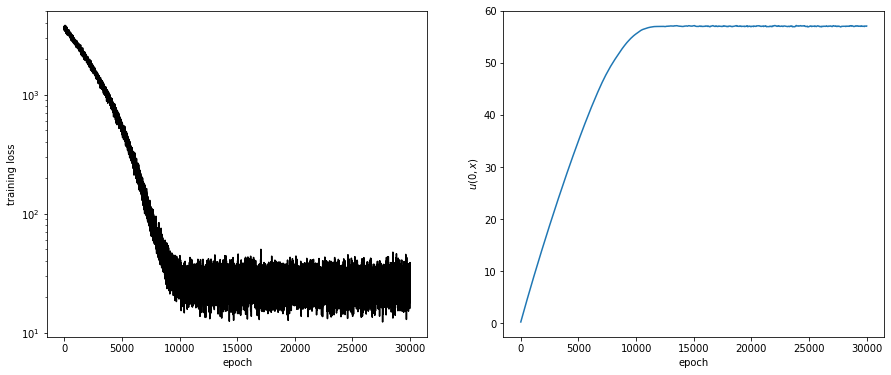

In [11]:
fig, ax = plt.subplots(1,2,figsize=(15,6))
xrange = range(len(history))
ax[0].semilogy(xrange, [e[1] for e in history],'k-')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('training loss')
ax[1].plot(xrange, [e[2] for e in history])
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('$u(0,x)$');

#### <font color='red'>Explanation and Conclusion</font>
The plot on the left shows the training loss as a function of epoch number, on a logarithmic scale. We see that the loss decreases rapidly at first and then more slowly, eventually plateauing around epoch 10000. The plot on the right shows the approximate value of $u(0,x)$ (which we've denoted as simply $y$) as a function of epoch number. The value of $y$ starts out near 0, which is far from the desired value of 57.3. However, as training proceeds, $y$ gradually approaches the target value, finally reaching it at around epoch 12000.

Overall, we can see that the training has been successful, as the loss has been minimized and the approximate solution $u(0,x)$ has converged to the target value.
